# CAP 5610 Homework 2 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import random
import os
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_file = os.path.join(os.getcwd(), 'train.csv')
test_file = os.path.join(os.getcwd(), 'test.csv')

In [3]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

In [4]:
train_x = train.drop(['Survived'], axis=1, inplace=False)

combined = pd.concat([train_x, test])

In [5]:
print('Train length: {}'.format(len(train)))
print('Test length: {}'.format(len(test)))
print('Combined length: {}'.format(len(combined)))

Train length: 891
Test length: 418
Combined length: 1309


In [6]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


#### Q9 - Pclass vs Survived

In [7]:
class1 = np.mean(train[train['Pclass'] == 1]['Survived'])
class2 = np.mean(train[train['Pclass'] == 2]['Survived'])
class3 = np.mean(train[train['Pclass'] == 3]['Survived'])

print('Average survival ratios: \n \
        class 1: {}\n \
        class 2: {}\n \
        class 3: {}'.format(class1, class2, class3))

Average survival ratios: 
         class 1: 0.6296296296296297
         class 2: 0.47282608695652173
         class 3: 0.24236252545824846


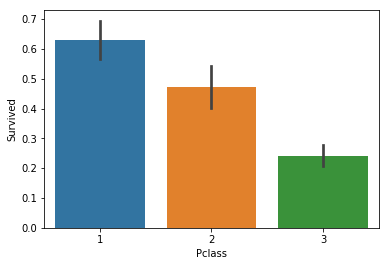

In [8]:
sns.barplot(x='Pclass', y='Survived', data=train)

#### Q10 - Gender vs Survived

In [9]:
men_survived = np.mean(train[train['Sex'] == 'male']['Survived'])
women_survived = np.mean(train[train['Sex'] == 'female']['Survived'])

print('Percent of men that survived: {}'.format(men_survived))
print('Percent of women that survived: {}'.format(women_survived))

Percent of men that survived: 0.18890814558058924
Percent of women that survived: 0.7420382165605095


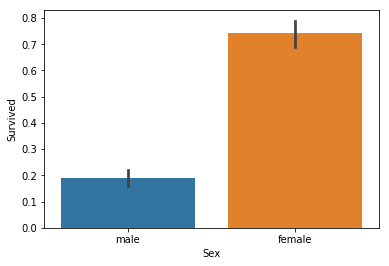

In [10]:
sns.barplot(x='Sex', y='Survived', data=train)

#### Q11 - Age vs Survived

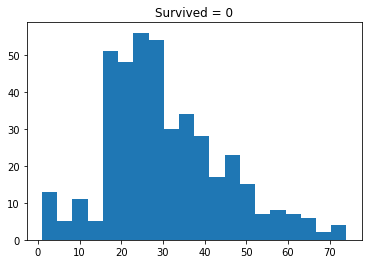

In [11]:
plt.hist(train[train['Survived']==0]['Age'], bins=20)
plt.title('Survived = 0')
plt.show()

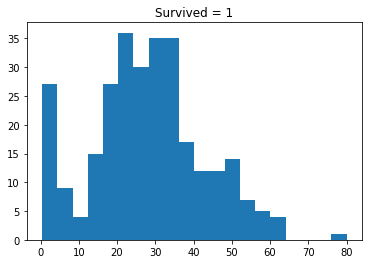

In [12]:
plt.hist(train[train['Survived']==1]['Age'], bins=20)
plt.title('Survived = 1')
plt.show()

#### Q12 - Age and PClass vs Survived

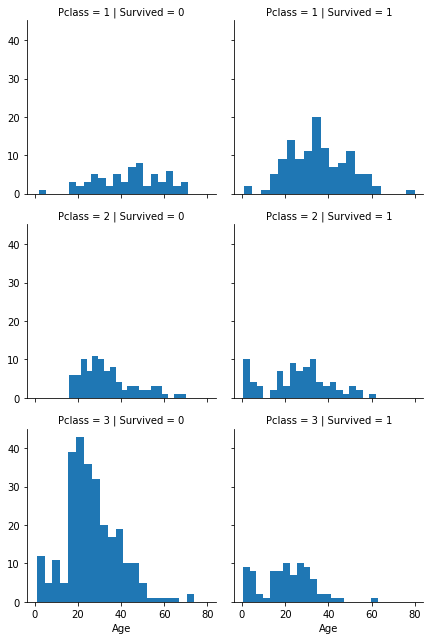

In [13]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()
plt.show()


#### Q13 - Embarked, Fare, and Gender vs Survival

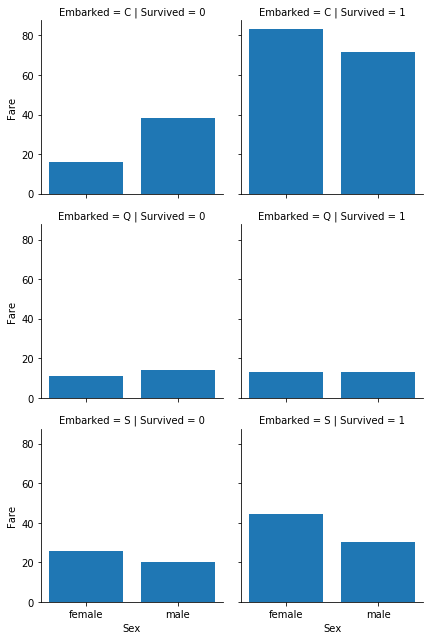

In [14]:
grouped = train.groupby(['Survived', 'Embarked', 'Sex']).mean().reset_index()
grid = sns.FacetGrid(grouped, col='Survived', row='Embarked')
grid.map(plt.bar, 'Sex', 'Fare')
grid.add_legend()
plt.show()

#### Q14 - Ticket duplicate values

In [15]:
dup = combined['Ticket'].duplicated().sum() / len(combined['Ticket'])

print('{}% of the tickets are duplicates'.
      format(round(dup*100, 2)))

29.03% of the tickets are duplicates


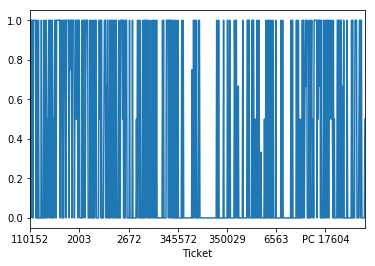

In [16]:
train.groupby('Ticket').mean()['Survived'].plot()

#### Q15 - Missing values for the Cabin feature

In [18]:
null_cabins = combined['Cabin'].isnull().sum()
percent_missing = null_cabins / len(combined['Cabin'])

print('{}, or {}%, of the cabin numbers are missing'.
      format(null_cabins, round(percent_missing*100, 2)))

1014, or 77.46%, of the cabin numbers are missing


#### Q16 - Gender to integer

In [19]:
combined['Gender'] = np.where(combined['Sex']=='female', 1, 0)
combined.drop(['Sex'], axis=1, inplace=True)

In [20]:
combined['Gender'].unique()

array([0, 1])

#### Q17 - fill missing age values with knn neighbors

In [21]:
print('Number of missing age values: ', 
      combined['Age'].isnull().sum())

Number of missing age values:  263


In [22]:
# Drop irrelevant categorical data
drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
knn_train = combined.drop(drop_cols, axis=1, inplace=False)

# Drop null rows
temp = knn_train.dropna(axis=0, inplace=False)

x = temp.drop('Age', axis=1)
y = temp['Age'].astype(int)
del temp

embarked_dict = {'S': 0, 'C': 1, 'Q': 2, None: 0}
# Convert embarked to numerical
x['Embarked'] = np.where(x['Embarked'] == 'S', 0, 
                            np.where(x['Embarked'] == 'C', 1, 2))

In [23]:
# Create and fit KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
# Loop through each row and replace missing age values with the average
# age of the data points 5 nearest neighbors
for i, row in combined.iterrows():
    if pd.isnull(row['Age']):
        row_data = row.drop(drop_cols + ['Age'], inplace=False)
        row_data['Embarked'] = embarked_dict[row_data['Embarked']]
        age_fill = knn.predict(np.array(row_data).reshape(1,-1))
        combined['Age'][i] =  age_fill

In [25]:
print('Number of missing age values after filling: ', 
      combined['Age'].isnull().sum())

Number of missing age values after filling:  0


#### Q18 - fill missing embarked values

In [26]:
print(combined['Embarked'].value_counts())
print(combined['Embarked'].value_counts().idxmax())

S    914
C    270
Q    123
Name: Embarked, dtype: int64
S


In [27]:
print('Number of missing embarked values: ', 
      combined['Embarked'].isnull().sum())

Number of missing embarked values:  2


In [28]:
combined['Embarked'].fillna('S', inplace=True)

In [29]:
print('Number of missing embarked values after filling ', 
      combined['Embarked'].isnull().sum())

Number of missing embarked values after filling  0


#### Q19 - fill missing fare values

In [30]:
print('The most common fare value is: ', combined['Fare'].mode()[0])

The most common fare value is:  8.05


In [31]:
print('Number of missing fare values: after filling ', 
      combined['Fare'].isnull().sum())

Number of missing fare values: after filling  1


In [32]:
combined['Fare'].fillna(combined['Fare'].mode()[0], inplace=True)

In [33]:
print('Number of missing fare values after filling ', 
      combined['Fare'].isnull().sum())

Number of missing fare values after filling  0


#### Q20 - Converting fare feature to ordinal datatype

In [34]:
combined['Fare'] = np.where(combined['Fare'] < 7.91, 0, 
                           np.where(combined['Fare'] < 14.454, 1,
                                    np.where(combined['Fare'] < 31.0, 2, 3)))

In [35]:
print('Fare values: ', sorted(combined['Fare'].unique()))

Fare values:  [0, 1, 2, 3]
